In this notebook, a first approach to learning and memory of the *Drosophila* is implemented: after having generating an attractive and an aversive gain, the fly explores the arena. This notebook shows step by step how the fly explores, then it gets respawned and it starts its exploration again.

In [8]:
import numpy as np
import os
from pathlib import Path
import logging
from tqdm import trange
from flygym.mujoco.arena import OdorArena
import matplotlib.pyplot as plt
from flygym.mujoco import Parameters
from gymnasium.utils.env_checker import check_env
from flygym.mujoco.examples.turning_controller import HybridTurningNMF


# Odor source: array of shape (num_odor_sources, 3) - xyz coords of odor sources
odor_source = np.array([[24, 0, 1.5], [8, -4, 1.5]])  # , [16, 4, 1.5]])

# Peak intensities: array of shape (num_odor_sources, odor_dimesions)
# For each odor source, if the intensity is (x, 0) then the odor is in the 1st dimension
# (in this case attractive). If it's (0, x) then it's in the 2nd dimension (in this case
# aversive)
peak_intensity = np.array([[1, 0], [0, 1]])  # , [0, 1]])

odor_dimesions = len(peak_intensity[0])

# The reward assigned to each source
odor_valence = [2, 1]

logging.basicConfig(level=logging.INFO)

In [9]:
# Set up the arena
arena = OdorArena(
    odor_source=odor_source,
    peak_intensity=peak_intensity,
    odor_valence=odor_valence,
    diffuse_func=lambda x: x**-2,
    marker_size=0.3,
)

(-0.5, 799.5, 607.5, -0.5)

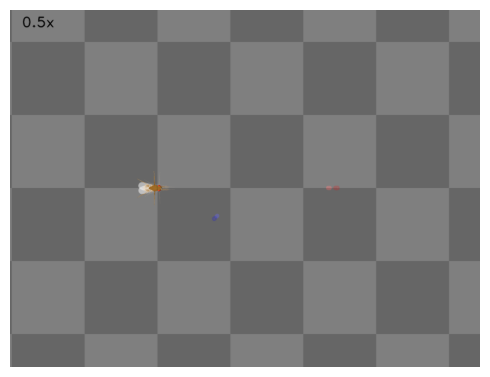

In [10]:
# Add the NeuroMechFLy
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]
sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.5,
    render_window_size=(800, 608),
    enable_olfaction=True,
    enable_adhesion=True,
    draw_adhesion=False,
    render_camera="birdeye_cam",
)
sim = HybridTurningNMF(
    sim_params=sim_params,
    arena=arena,
    spawn_pos=(0, 0, 0.2),
    contact_sensor_placements=contact_sensor_placements,
    simulation_time=10,
)
for i in range(1):
    sim.step(np.zeros(2))
    sim.render()
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.imshow(sim._frames[-1])
ax.axis("off")
#fig.savefig("./outputs/olfaction_env.png")

In [11]:
# Print the actual time before the start of the simulation
sim.curr_time

0.0001

In [12]:
# The exploration starts
# we can compute random gains using the arena.generate_random_gains() function or
# we can define them manually
explore = True
attractive_gain, aversive_gain = arena.generate_random_gains(explore)
"""attractive_gain = 10
aversive_gain = -200"""
decision_interval = 0.05
run_time = sim.simulation_time
num_decision_steps = int(run_time / decision_interval)
physics_steps_per_decision_step = int(decision_interval / sim_params.timestep)

obs_hist = []
odor_history = []
obs, _ = sim.reset()
for i in trange(num_decision_steps):
    attractive_intensities = np.average(
        obs["odor_intensity"][0, :].reshape(2, 2), axis=0, weights=[9, 1]
    )
    aversive_intensities = np.average(
        obs["odor_intensity"][1, :].reshape(2, 2), axis=0, weights=[10, 0]
    )
    attractive_bias = (
        attractive_gain
        * (attractive_intensities[0] - attractive_intensities[1])
        / attractive_intensities.mean()
    )
    aversive_bias = (
        aversive_gain
        * (aversive_intensities[0] - aversive_intensities[1])
        / aversive_intensities.mean()
    )
    effective_bias = aversive_bias + attractive_bias
    effective_bias_norm = np.tanh(effective_bias**2) * np.sign(effective_bias)
    assert np.sign(effective_bias_norm) == np.sign(effective_bias)

    control_signal = np.ones((2,))
    side_to_modulate = int(effective_bias_norm > 0)
    modulation_amount = np.abs(effective_bias_norm) * 0.8
    control_signal[side_to_modulate] -= modulation_amount

    for j in range(physics_steps_per_decision_step):
        obs, reward, terminated, truncated, _ = sim.step(control_signal)
        rendered_img = sim.render()
        if rendered_img is not None:
            # record odor intensity too for video
            odor_history.append(obs["odor_intensity"])
        obs_hist.append(obs)

        if reward != None:
            logging.info("A reward was found, let's start again exploring")
            logging.info("Elapsed time in the simulation", sim.curr_time)
            break
        if terminated:
            logging.info(
                "Time for the simulation has elapsed. Simulation is terminated"
            )
            logging.info("Elapsed time in the simulation", sim.curr_time)
            break
        if truncated:
            logging.info("A reward was not found, simulation is truncated")
            logging.info("Elapsed time in the simulation", sim.curr_time)
            break

100%|██████████| 200/200 [01:54<00:00,  1.74it/s]


In [13]:
# Check the current time in the simulation
print(sim.curr_time)
# Check if any reward has been found
print(sim.fly_valence_dictionary)

3.688400000003359
{1: 2}


In [15]:
# Choose a name to save both the video and the trajectory
name = "basic_random_simulation_"
path = Path(f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}")
os.mkdir(path)

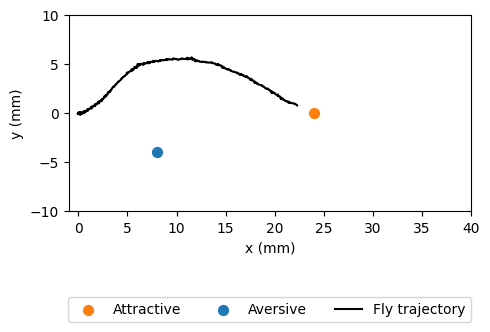

In [17]:
# Plot the trajectory
fly_pos_hist = np.array([obs["fly"][0, :2] for obs in obs_hist])
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.scatter(
    [odor_source[0, 0]],
    [odor_source[0, 1]],
    marker="o",
    color="tab:orange",
    s=50,
    label="Attractive",
)
ax.scatter(
    [odor_source[1, 0]],
    [odor_source[1, 1]],
    marker="o",
    color="tab:blue",
    s=50,
    label="Aversive",
)
# ax.scatter([odor_source[2, 0]], [odor_source[2, 1]], marker="o", color="tab:blue", s=50)
ax.plot(fly_pos_hist[:, 0], fly_pos_hist[:, 1], color="k", label="Fly trajectory")
ax.set_aspect("equal")
ax.set_xlim(-1, 40)
ax.set_ylim(-10, 10)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.6))
fig.savefig(f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}/odor_taxis_trajectory.png")

In [18]:
sim.save_video(
    f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}/odor_taxis_video.mp4"
)

In [ ]:
# The fly is respawned to its original position
_, _ = sim.respawn()

In [ ]:
# The gains for the new exploration are generated
attractive_gain, aversive_gain = arena.generate_random_gains(explore)
print(attractive_gain, aversive_gain)

In [ ]:
# The fly explores the arena
for i in trange(num_decision_steps):
    attractive_intensities = np.average(
        obs["odor_intensity"][0, :].reshape(2, 2), axis=0, weights=[9, 1]
    )
    aversive_intensities = np.average(
        obs["odor_intensity"][1, :].reshape(2, 2), axis=0, weights=[10, 0]
    )
    attractive_bias = (
        attractive_gain
        * (attractive_intensities[0] - attractive_intensities[1])
        / attractive_intensities.mean()
    )
    aversive_bias = (
        aversive_gain
        * (aversive_intensities[0] - aversive_intensities[1])
        / aversive_intensities.mean()
    )
    effective_bias = aversive_bias + attractive_bias
    effective_bias_norm = np.tanh(effective_bias**2) * np.sign(effective_bias)
    assert np.sign(effective_bias_norm) == np.sign(effective_bias)

    control_signal = np.ones((2,))
    side_to_modulate = int(effective_bias_norm > 0)
    modulation_amount = np.abs(effective_bias_norm) * 0.8
    control_signal[side_to_modulate] -= modulation_amount

    for j in range(physics_steps_per_decision_step):
        obs, reward, terminated, truncated, _ = sim.step(control_signal)
        rendered_img = sim.render()
        if rendered_img is not None:
            # record odor intensity too for video
            odor_history.append(obs["odor_intensity"])
        obs_hist.append(obs)

        if reward != None:
            logging.info("A reward was found, let's start again exploring")
            logging.info("Elapsed time in the simulation", sim.curr_time)
            break
        if terminated:
            logging.info(
                "Time for the simulation has elapsed. Simulation is terminated"
            )
            logging.info("Elapsed time in the simulation", sim.curr_time)
            break
        if truncated:
            logging.info("A reward was not found, simulation is truncated")
            logging.info("Elapsed time in the simulation", sim.curr_time)
            break

In [ ]:
# Check the elapsed time in the simulation
print(sim.elapsed_time)

In [ ]:
# Plotting the updated trajectory
fly_pos_hist = np.array([obs["fly"][0, :2] for obs in obs_hist])
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.scatter(
    [odor_source[0, 0]],
    [odor_source[0, 1]],
    marker="o",
    color="tab:orange",
    s=50,
    label="Attractive",
)
ax.scatter(
    [odor_source[1, 0]],
    [odor_source[1, 1]],
    marker="o",
    color="tab:blue",
    s=50,
    label="Aversive",
)
# ax.scatter([odor_source[2, 0]], [odor_source[2, 1]], marker="o", color="tab:blue", s=50)
ax.plot(fly_pos_hist[:, 0], fly_pos_hist[:, 1], color="k", label="Fly trajectory")
ax.set_aspect("equal")
ax.set_xlim(-1, 40)
ax.set_ylim(-5, 5)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.6))
fig.savefig(f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}/odor_taxis_trajectory.png")

In [ ]:
sim.save_video(
    f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}/odor_taxis_video_.mp4"
)

In [ ]:
# The fly is respawned to its original position
_, _ = sim.respawn()

In [ ]:
# In this case, we are guiding the fly towards the aversive source by setting 
# the gains manually
attractive_gain = 80
aversive_gain = -500
for i in trange(num_decision_steps):
    attractive_intensities = np.average(
        obs["odor_intensity"][0, :].reshape(2, 2), axis=0, weights=[9, 1]
    )
    aversive_intensities = np.average(
        obs["odor_intensity"][1, :].reshape(2, 2), axis=0, weights=[10, 0]
    )
    attractive_bias = (
        attractive_gain
        * (attractive_intensities[0] - attractive_intensities[1])
        / attractive_intensities.mean()
    )
    aversive_bias = (
        aversive_gain
        * (aversive_intensities[0] - aversive_intensities[1])
        / aversive_intensities.mean()
    )
    effective_bias = aversive_bias + attractive_bias
    effective_bias_norm = np.tanh(effective_bias**2) * np.sign(effective_bias)
    assert np.sign(effective_bias_norm) == np.sign(effective_bias)

    control_signal = np.ones((2,))
    side_to_modulate = int(effective_bias_norm > 0)
    modulation_amount = np.abs(effective_bias_norm) * 0.8
    control_signal[side_to_modulate] -= modulation_amount

    for j in range(physics_steps_per_decision_step):
        obs, reward, terminated, truncated, _ = sim.step(control_signal)
        rendered_img = sim.render()
        if rendered_img is not None:
            # record odor intensity too for video
            odor_history.append(obs["odor_intensity"])
        obs_hist.append(obs)

        if reward != None:
            logging.info("A reward was found, let's start again exploring")
            logging.info("Elapsed time in the simulation", sim.curr_time)
            break
        if terminated:
            logging.info(
                "Time for the simulation has elapsed. Simulation is terminated"
            )
            logging.info("Elapsed time in the simulation", sim.curr_time)
            break
        if truncated:
            logging.info("A reward was not found, simulation is truncated")
            logging.info("Elapsed time in the simulation", sim.curr_time)
            break

In [ ]:
# Plotting the updated trajectory
fly_pos_hist = np.array([obs["fly"][0, :2] for obs in obs_hist])
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.scatter(
    [odor_source[0, 0]],
    [odor_source[0, 1]],
    marker="o",
    color="tab:orange",
    s=50,
    label="Attractive",
)
ax.scatter(
    [odor_source[1, 0]],
    [odor_source[1, 1]],
    marker="o",
    color="tab:blue",
    s=50,
    label="Aversive",
)
# ax.scatter([odor_source[2, 0]], [odor_source[2, 1]], marker="o", color="tab:blue", s=50)
ax.plot(fly_pos_hist[:, 0], fly_pos_hist[:, 1], color="k", label="Fly trajectory")
ax.set_aspect("equal")
ax.set_xlim(-1, 40)
ax.set_ylim(-5, 5)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.6))
fig.savefig(f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}/odor_taxis_trajectory.png")

In [ ]:
sim.save_video(sim.save_video(
    f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}/odor_taxis_video_1.mp4"
))